<a href="https://colab.research.google.com/github/bbchen33/Flow_Cytometry/blob/master/Flow_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing Flow Cytometry data with FlowCal package

These samples contain
1. live + dead cells
2. Counting beads (Alexa 405 positive)
3. Zombie Red viability dye (Texas Red positive for dead cells)

In [1]:
!pip install --quiet FlowCal # install the package

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 143kB 7.7MB/s 


In [2]:
import FlowCal

Loading the samples with FlowCal 
1. "killed": heat-killed cells as the control
2. "tp0": cells from time point 0, mostly alive.

In [31]:
from google.colab import files
files.upload()

Saving time pt 16h_Tube_001.fcs to time pt 16h_Tube_001.fcs
Saving time pt 16h_Tube_004.fcs to time pt 16h_Tube_004.fcs


{'time pt 16h_Tube_001.fcs': b'FCS3.0         256    4091    4097  443696       0       0                                                                                                                                                                                                      \x0c$BEGINANALYSIS\x0c0\x0c$ENDANALYSIS\x0c0\x0c$BEGINSTEXT\x0c0\x0c$ENDSTEXT\x0c0\x0c$BEGINDATA\x0c4097\x0c$ENDDATA\x0c443696             \x0c$FIL\x0ctime pt 16h_Tube_001.fcs\x0c$SYS\x0cWindows XP 5.1\x0c$TOT\x0c5495               \x0c$PAR\x0c20\x0c$MODE\x0cL\x0c$BYTEORD\x0c4,3,2,1\x0c$DATATYPE\x0cF\x0c$NEXTDATA\x0c0\x0cCREATOR\x0cBD FACSDiva Software Version 6.1.3\x0cTUBE NAME\x0cTube_001\x0c$SRC\x0ctime pt 16h\x0cEXPERIMENT NAME\x0cMIF survival 3-14-15\x0cGUID\x0c8d29b2b6-5409-44bb-a5ea-e0fed512f6e2\x0c$DATE\x0c15-MAR-2015\x0c$BTIM\x0c11:31:50\x0c$ETIM\x0c11:32:37\x0c$CYT\x0cLSRII\x0cCYTNUM\x0cH79700001\x0cWINDOW EXTENSION\x0c10.00\x0cEXPORT USER NAME\x0cbbchen33\x0cEXPORT TIME\x0c15-MAR-2015-11:39:24

In [4]:
killed = FlowCal.io.FCSData('Time pt 0h_killed E.fcs')
killed = FlowCal.transform.to_rfi(killed)
tp0 = FlowCal.io.FCSData('Time pt 0h_Tube_001.fcs')
tp0 = FlowCal.transform.to_rfi(tp0)

In [32]:
tp16_1 = FlowCal.io.FCSData('time pt 16h_Tube_001.fcs')
tp16_1 = FlowCal.transform.to_rfi(tp16_1)
tp16_4 = FlowCal.io.FCSData('time pt 16h_Tube_004.fcs')
tp16_4 = FlowCal.transform.to_rfi(tp16_4)

A quick function to plot the flow scatterplot showing FSC and SSC axes. 

In [7]:
import matplotlib.pyplot as plt

def flow_scatter(sample_name):
  FlowCal.plot.density2d(sample_name, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.xlim((6*10**3,10**6))
  plt.ylim((6*10**3,10**6))
  plt.title(sample_name)
  plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


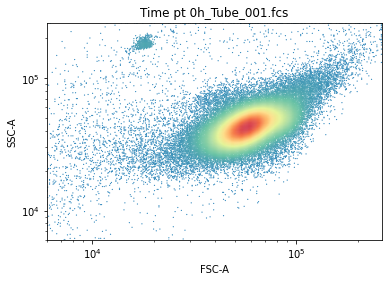

In [8]:
flow_scatter(tp0)

A function to gate on Alexa 405-positive beads: 
1. Gate the beads based on size
2. Filter the gated beads based on Alexa 405 signal (positive)

In [9]:
import warnings
warnings.filterwarnings("ignore")
def gate_beads(sample_name, x = 4.2, y = 5.4): # x and y are the center of where the beads are expected
  # Gating beads by size
  beads = FlowCal.gate.ellipse(sample_name, channels = ['FSC-A', 'SSC-A'],
                             log = True,
                             center = (x, y), a = 0.2, b = 0.2)
  # Gating beads by Alexa 405 signal
  beads_pos = FlowCal.gate.high_low(beads, channels='Alexa Fluor 405-A', 
                               high=10**5, low=1.5*10**4)
  plt.figure(figsize=(6,12))
  plt.subplots_adjust(hspace = 0.4)
  plt.subplot(311)
  FlowCal.plot.density2d(beads, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.title('Before filtering by Alexa 405 signal')
  plt.xlim((10**4,10**6))
  plt.ylim((10**4,10**6))
  plt.subplot(312)
  FlowCal.plot.density2d(beads_pos, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.xlim((10**4,10**6))
  plt.ylim((10**4,10**6))
  plt.title('After filtering by positive-Alexa 405 signal')

  plt.subplot(313)
  FlowCal.plot.hist1d(beads_pos, channel = 'Alexa Fluor 405-A')
  plt.title('After filtering by Alexa 405 signal - Histogram')

  print('Number of beads: ', beads_pos.shape[0])
  return beads_pos

Number of beads:  1262


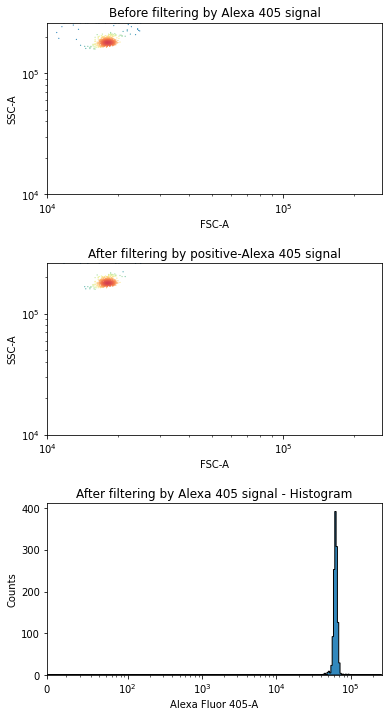

In [10]:
beads = gate_beads(tp0)

Gating live cells.
1. First gate the cells based on FSC and SSC
2. Then filter out cells if Zombie Red positive (= dead cells)

In [13]:
import numpy as np
def gate_live_cells(samples):
  # Gating cells by size
  live_cells = FlowCal.gate.ellipse(samples, channels = ['FSC-A','SSC-A'], 
                                    log = True, center = (5, 4.7),
                                    a = 0.6, b = 0.4, theta = 50/180.*np.pi)
  
  # Gating live cells by negative Texas Red
  zom_neg = FlowCal.gate.high_low(live_cells, channels='PE-Texas Red-A', 
                               high=6*10**3, low=100)
  plt.figure(figsize=(6,8))
  plt.subplots_adjust(hspace = 0.4)
  
  plt.subplot(211)
  FlowCal.plot.density2d(zom_neg, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.title('Gated live cells')
  plt.xlim((10**4,10**6))
  plt.ylim((10**4,10**6))

  plt.subplot(212)
  FlowCal.plot.hist1d(zom_neg, channel = 'PE-Texas Red-A')
  plt.title('Zombie Red signal from gated cells')
  print('number of live cells: ', zom_neg.shape[0])
  return zom_neg


number of live cells:  85022


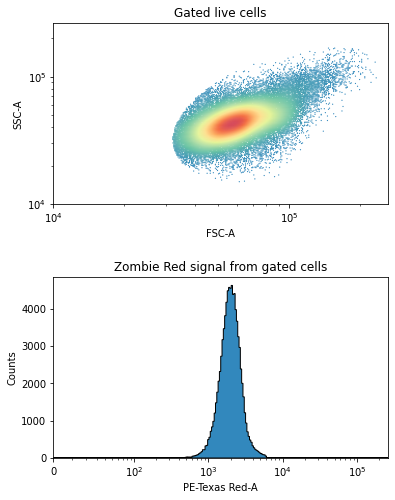

In [14]:
live_tp0 = gate_live_cells(tp0)

number of live cells:  14


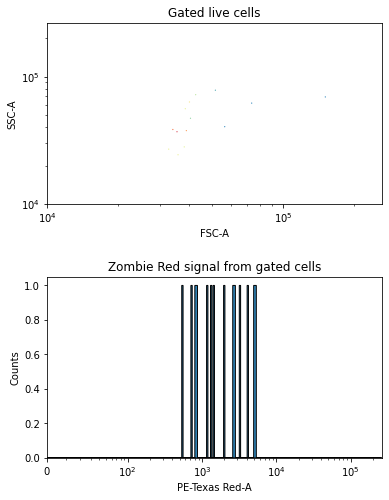

In [15]:
live_killed = gate_live_cells(killed) # only 14 live cells in the killed sample

A function to count live cells in the sample = 1000*number of live cells / counting beads 

In [28]:
def count_live_cells(sample_name):
  beads = FlowCal.gate.ellipse(sample_name, channels = ['FSC-A', 'SSC-A'],
                             log = True,
                             center = (4.2,5.4), a = 0.2, b = 0.2)
  beads_pos = FlowCal.gate.high_low(beads, channels='Alexa Fluor 405-A', 
                               high=10**5, low=1.5*10**4)
  bead_count = beads_pos.shape[0]

  live_cells = FlowCal.gate.ellipse(sample_name, channels = ['FSC-A','SSC-A'], 
                                    log = True, center = (5, 4.7),
                                    a = 0.6, b = 0.4, theta = 50/180.*np.pi)
  
  
  zom_neg = FlowCal.gate.high_low(live_cells, channels='PE-Texas Red-A', 
                               high=6*10**3, low=100)
  live_cell_count = zom_neg.shape[0]
  return int(1000*live_cell_count/bead_count)

Counting live cells in each sample in the directory

In [39]:
import glob
file_ls = []
for file in glob.glob('*.fcs') :
  temp = FlowCal.io.FCSData(file)
  file_ls.append(FlowCal.transform.to_rfi(temp))

In [44]:
for file in file_ls:
  print(file, 'has', count_live_cells(file), 'cells')

time pt 16h_Tube_001.fcs has 2516 cells
Time pt 0h_killed E.fcs has 15 cells
Time pt 0h_Tube_001.fcs has 67370 cells
time pt 16h_Tube_004.fcs has 13969 cells
